In [2]:
import os
import random
import tqdm

import numpy as np
import cv2

import matplotlib.pyplot as plt

PATH = os.getcwd()

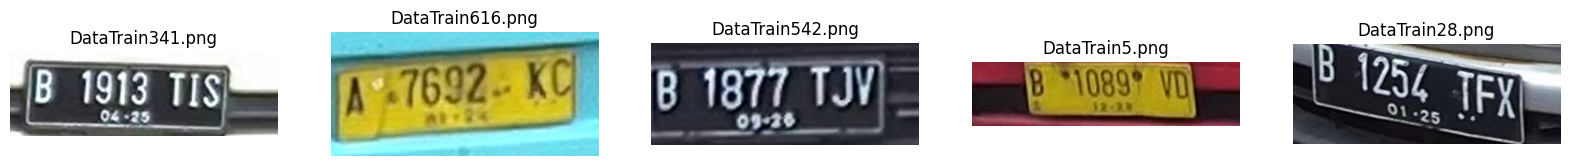

In [6]:
# files = os.listdir(os.path.join(PATH, 'TrainAnnotation'))
# print(f'Total number of files: {len(files)}')

# # pick random files
# random_files = random.sample(files, 5)\

random_files = ['DataTrain341.png',
 'DataTrain616.png',
 'DataTrain542.png',
 'DataTrain5.png',
 'DataTrain28.png']

fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for ax, img_file in zip(axes, random_files):
    image = cv2.imread(os.path.join(PATH, 'Train', img_file))
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax.axis('off')
    ax.set_title(img_file)

plt.show()

random_images = [cv2.imread(os.path.join(PATH, 'Train', img_file)) for img_file in random_files]

# Preprocessing


In [7]:
def process_image(image, idx):
    '''
    Fungsi untuk preprocessing citra hingga menjadi citra biner yang siap untuk dilakukan ekstraksi fitur.
    Input:
    - image: citra yang akan diproses
    - idx: indeks citra yang sedang diproses

    Output:
    - image: citra hasil preprocessing
    '''

    fig, axes = plt.subplots(2, 3, figsize=(15, 6))
    axes = axes.ravel()

    # Citra asli
    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Konversi ke Greyscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    axes[1].imshow(image, cmap='gray')
    axes[1].set_title('Greyscale Image')
    axes[1].axis('off')
    
    # Penerapan bilateral filter
    # image = cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)
    image = cv2.bilateralFilter(image, d=3, sigmaColor=75, sigmaSpace=75)
    axes[2].imshow(image, cmap='gray')
    axes[2].set_title('Bilateral Filtered Image')
    axes[2].axis('off')
    
    # Penerapan Normalisasi CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image = clahe.apply(image)
    axes[3].imshow(image, cmap='gray')
    axes[3].set_title('CLAHE Image')
    axes[3].axis('off')
    
    # Thresholding
    # _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) # Thresholding Otsu
    # image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    _, image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV) # Thresholding biasa
    if np.sum(image == 0) > np.sum(image == 255):
        image = cv2.bitwise_not(image)
    axes[4].imshow(image, cmap='gray')
    axes[4].set_title('Thresholded Image')
    axes[4].axis('off')
    
    # Penerapan dilasi dengan kernel strel 3x3
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    image = cv2.bitwise_not(image)
    image = cv2.erode(image, kernel, iterations=1)
    image = cv2.dilate(image, kernel, iterations=1)
    image = cv2.bitwise_not(image)
    axes[5].imshow(image, cmap='gray')
    axes[5].set_title('Dilated Image')
    axes[5].axis('off')
    
    # plt.tight_layout()
    # plt.savefig(f'./plots/{idx}.png')
    fig.suptitle(f'Preprocessing Steps for Image {idx}', fontsize=16)
    plt.show()
    plt.close()
    return image

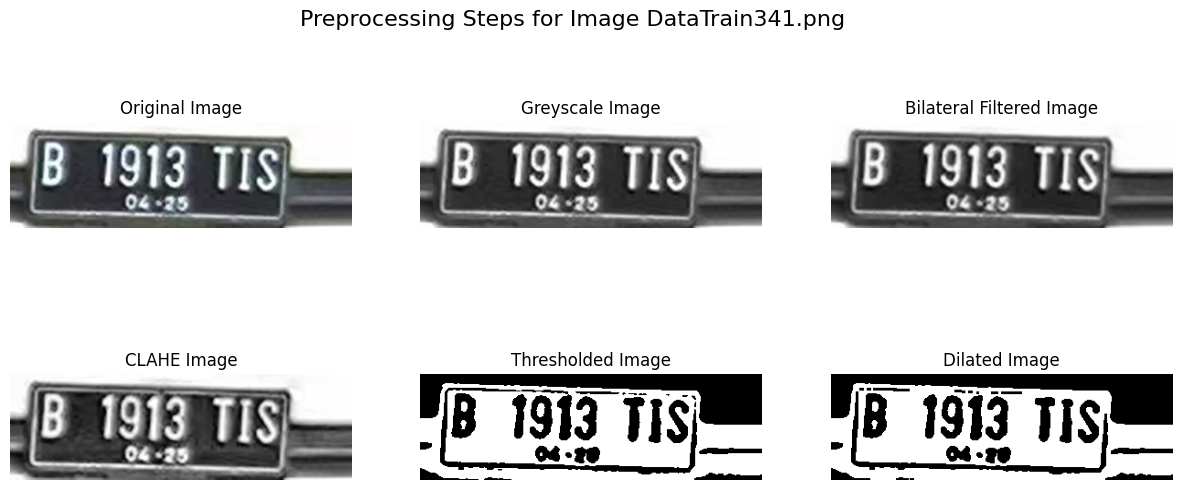

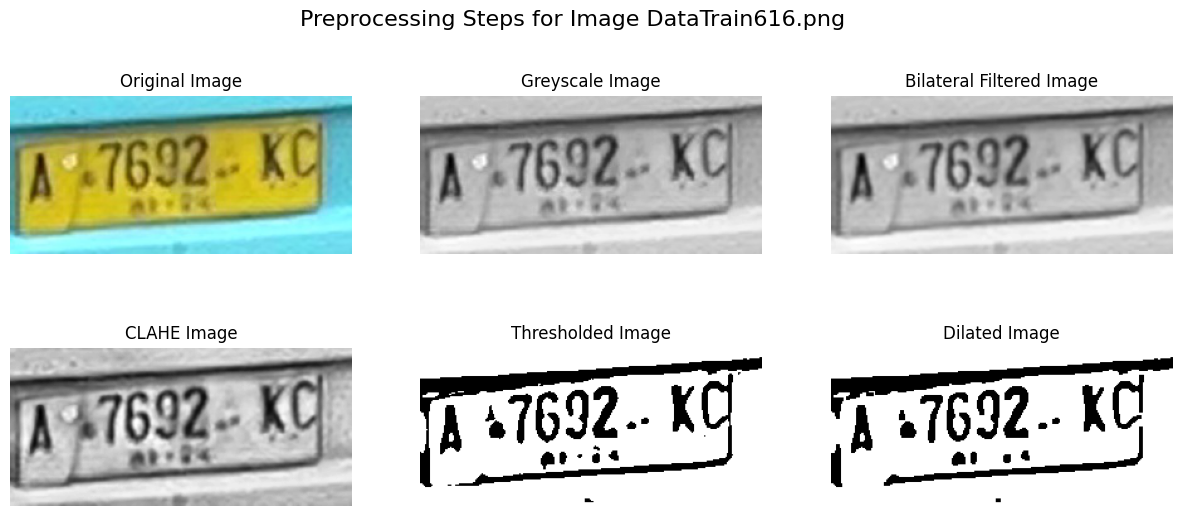

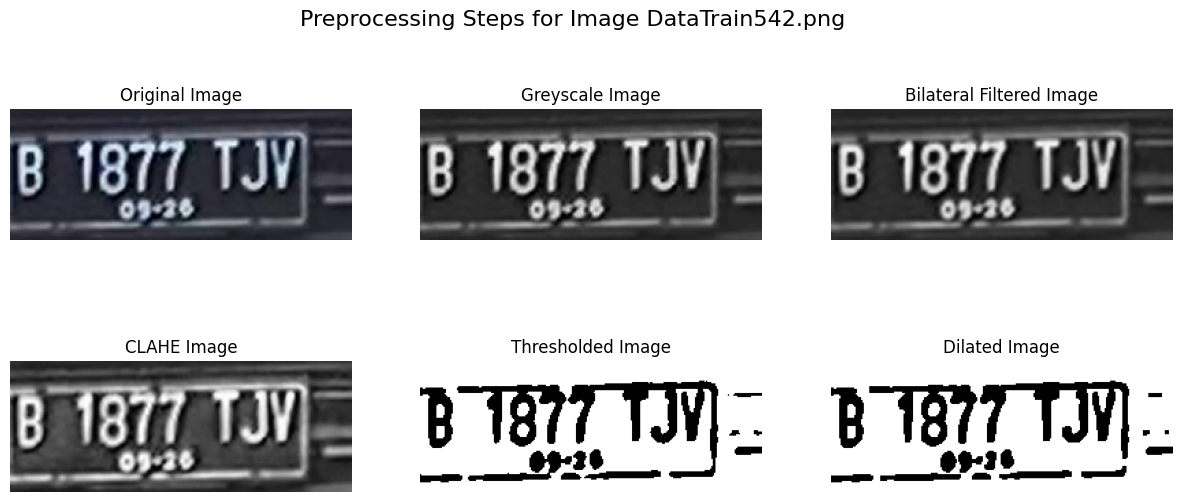

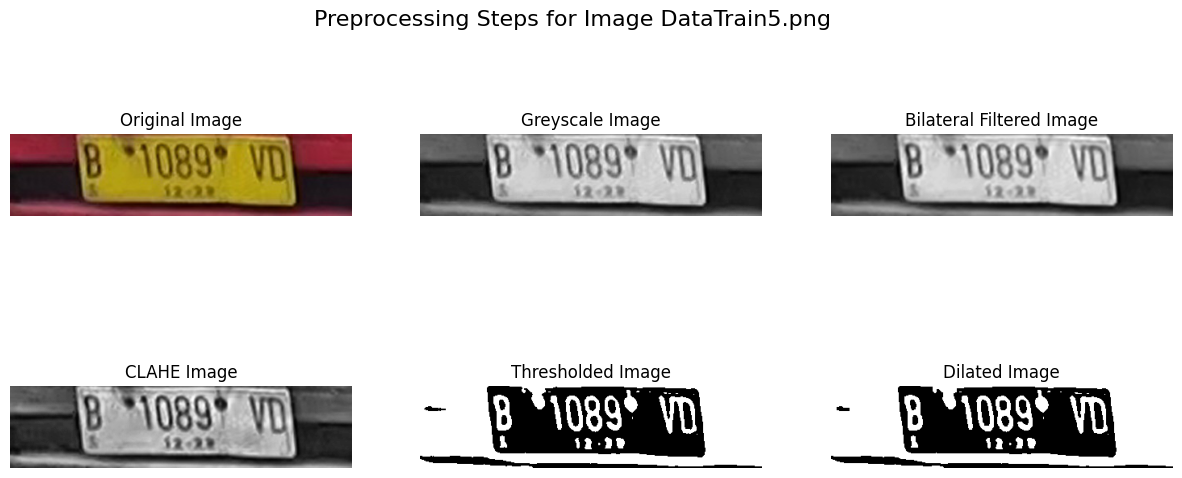

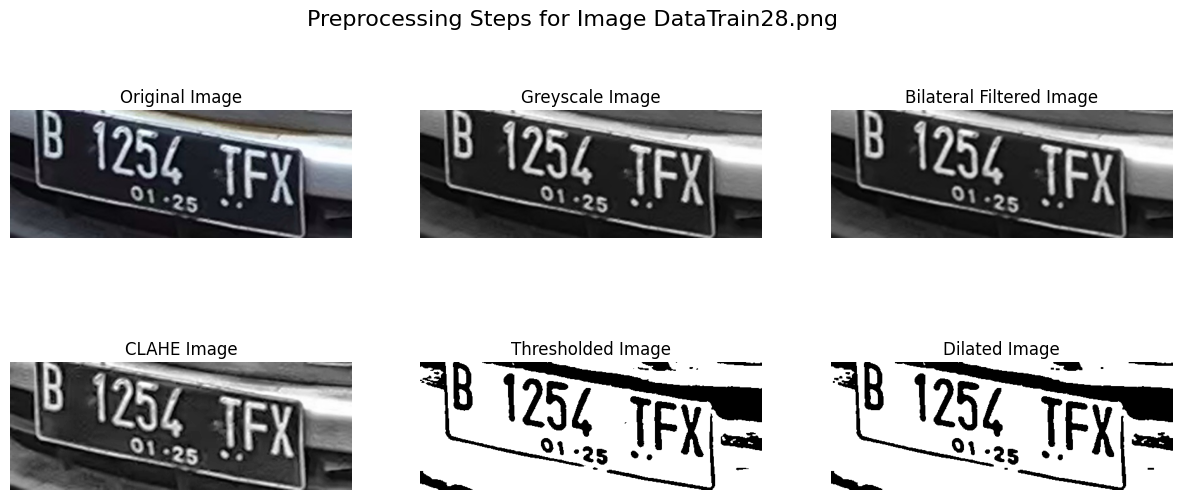

In [8]:
preprocessed_image = [process_image(image, idx) for image, idx in zip(random_images, random_files)]

# Localization

In [18]:
def dynamic_canny(image, sigma=0.33):
    '''
    Fungsi untuk menghitung nilai threshold bawah dan atas secara dinamis
    berdasarkan median intensitas pada gambar.
    Input:
    - image: citra grayscale yang akan diproses
    - sigma: parameter untuk mengontrol lebar rentang threshold (default: 0.33)

    Output:
    - edges: citra hasil deteksi tepi menggunakan Canny
    '''
    # Menghitung nilai median dari citra
    v = np.median(image)

    # Menentukan threshold bawah dan atas
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))

    # Deteksi tepi menggunakan threshold dinamis
    edges = cv2.Canny(image, lower, upper)
    return edges

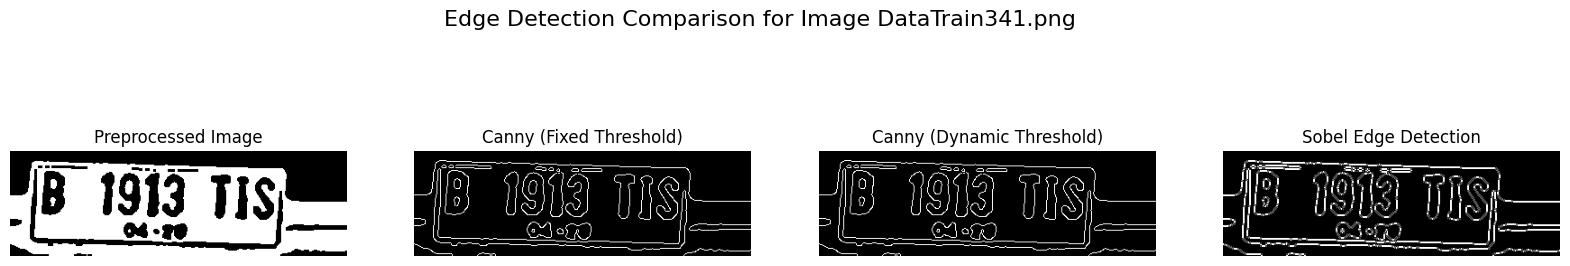

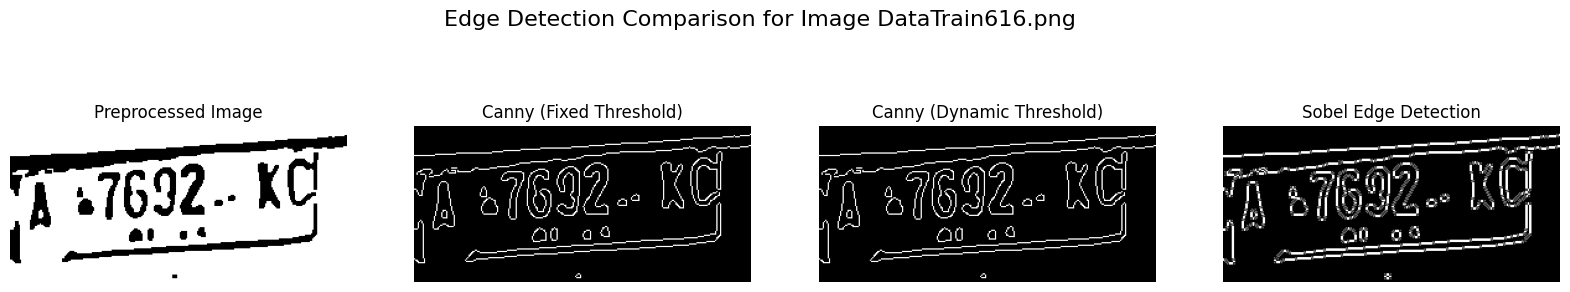

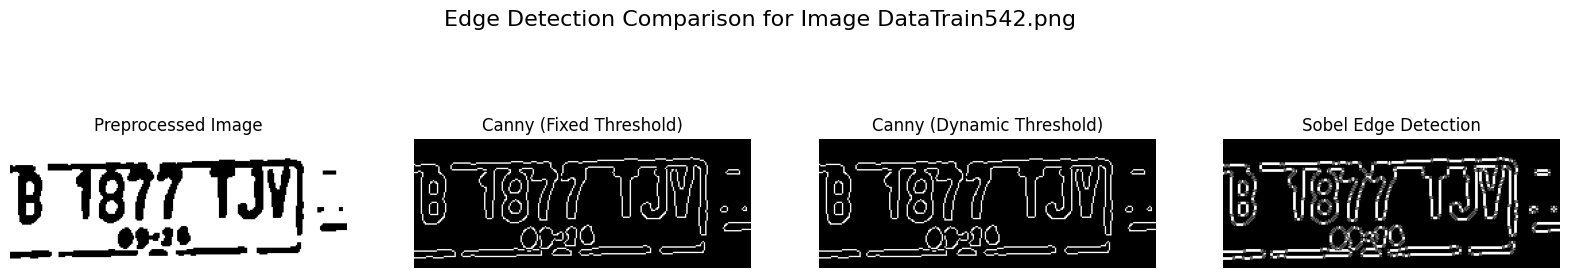

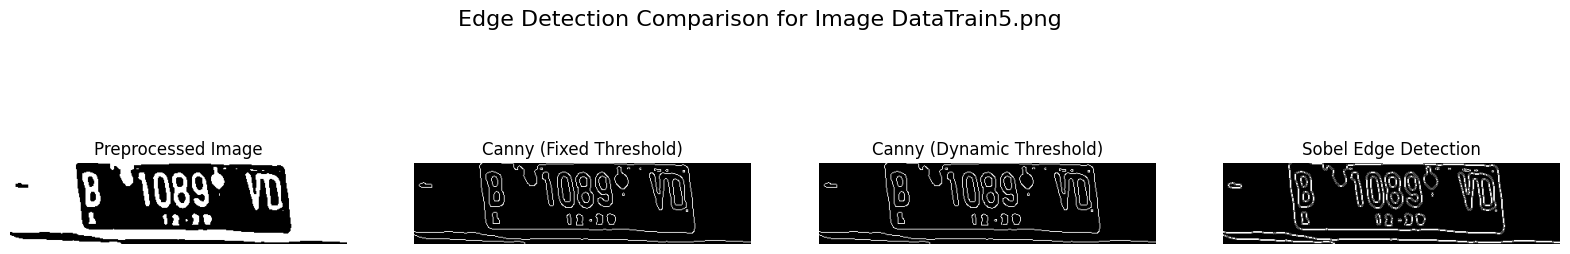

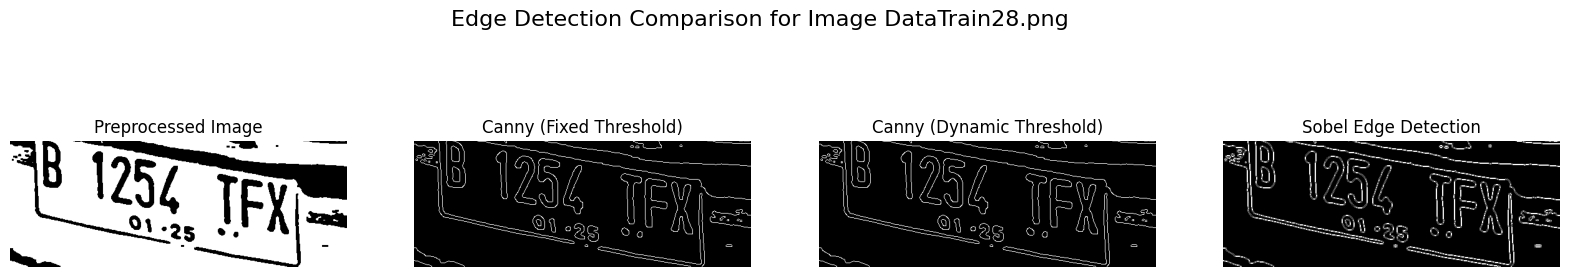

In [23]:
def localize_and_compare(image, idx):
    '''
    Fungsi untuk melokalisasi citra plat nomor menggunakan deteksi tepi Canny (dengan parameter dinamis) 
    dan Sobel, kemudian membandingkan hasilnya secara berdampingan.
    Input:
    - image: citra yang akan diproses
    - idx: indeks citra yang sedang diproses

    Output:
    - canny_edges: citra hasil deteksi tepi Canny
    - sobel_edges: citra hasil deteksi tepi Sobel
    '''

    fig, axes = plt.subplots(1, 4, figsize=(20, 4))  # Menambah satu kolom untuk Dynamic Canny
    axes = axes.ravel()

    # Konversi gambar ke grayscale jika belum
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image

    # Citra asli
    axes[0].imshow(gray_image, cmap='gray')
    axes[0].set_title('Preprocessed Image')
    axes[0].axis('off')

    # Deteksi tepi menggunakan Canny (Fixed Threshold)
    fixed_canny_edges = cv2.Canny(gray_image, 100, 200)
    axes[1].imshow(fixed_canny_edges, cmap='gray')
    axes[1].set_title('Canny (Fixed Threshold)')
    axes[1].axis('off')

    # Deteksi tepi menggunakan Canny (Dynamic Threshold)
    dynamic_canny_edges = dynamic_canny(gray_image)
    axes[2].imshow(dynamic_canny_edges, cmap='gray')
    axes[2].set_title('Canny (Dynamic Threshold)')
    axes[2].axis('off')

    # Deteksi tepi menggunakan Sobel
    sobelx = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)
    sobel_edges = cv2.magnitude(sobelx, sobely)
    sobel_edges = np.uint8(sobel_edges)
    axes[3].imshow(sobel_edges, cmap='gray')
    axes[3].set_title('Sobel Edge Detection')
    axes[3].axis('off')

    fig.suptitle(f'Edge Detection Comparison for Image {idx}', fontsize=16)
    plt.show()
    plt.close()

    return fixed_canny_edges, dynamic_canny_edges, sobel_edges

# Proses semua gambar
localized_images = [localize_and_compare(image, idx) for image, idx in zip(preprocessed_image, random_files)]


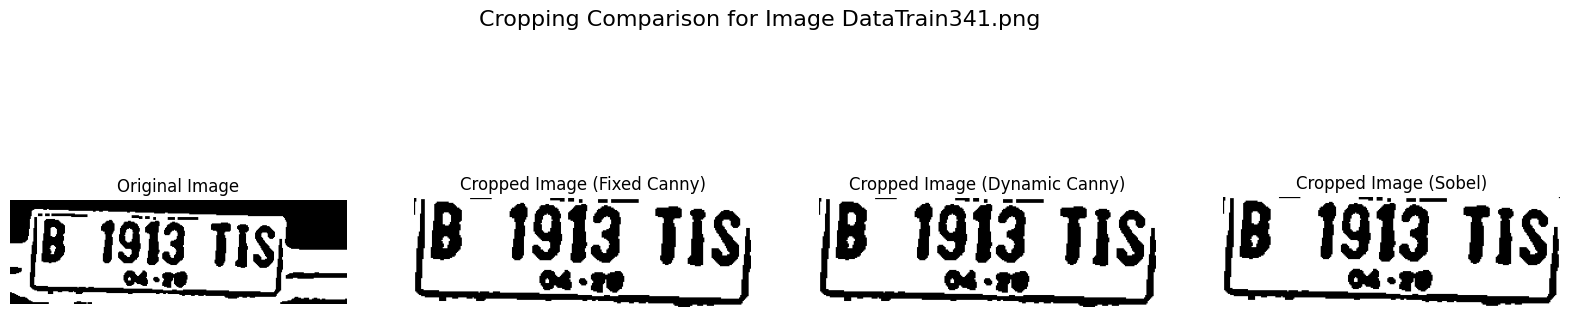

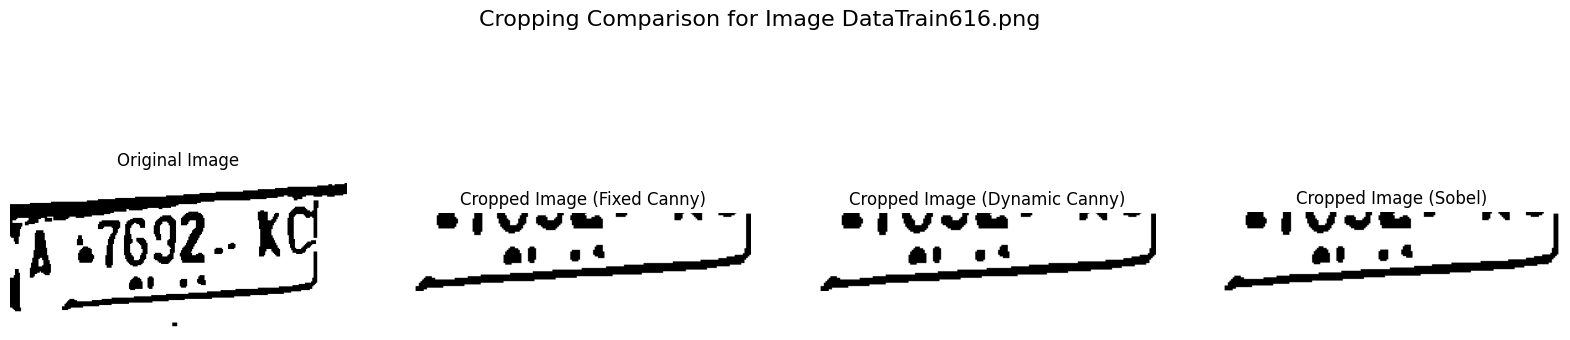

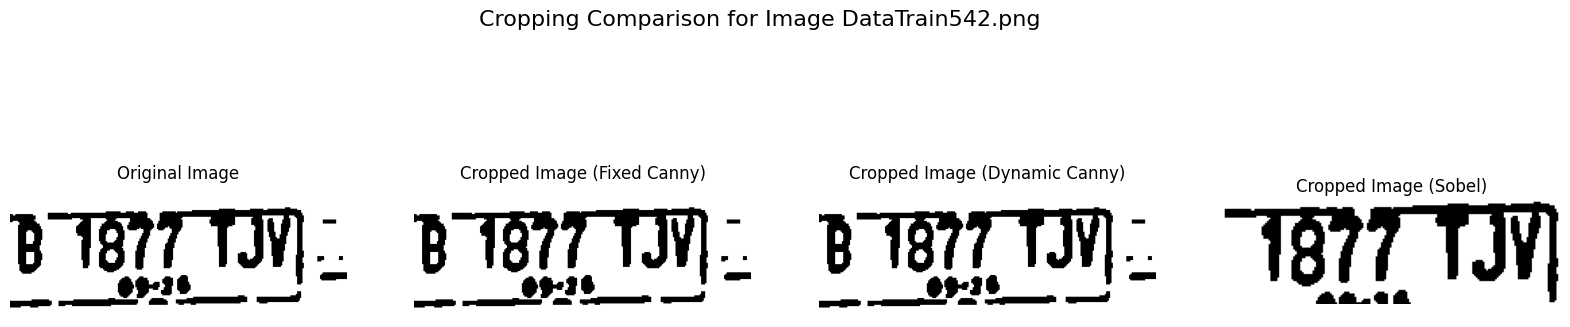

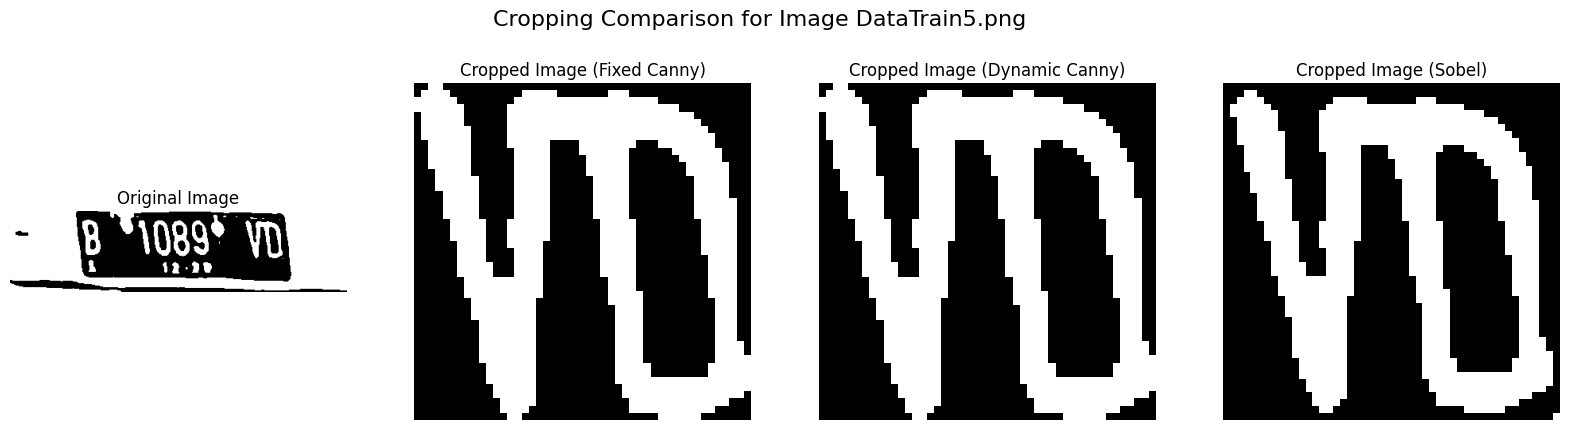

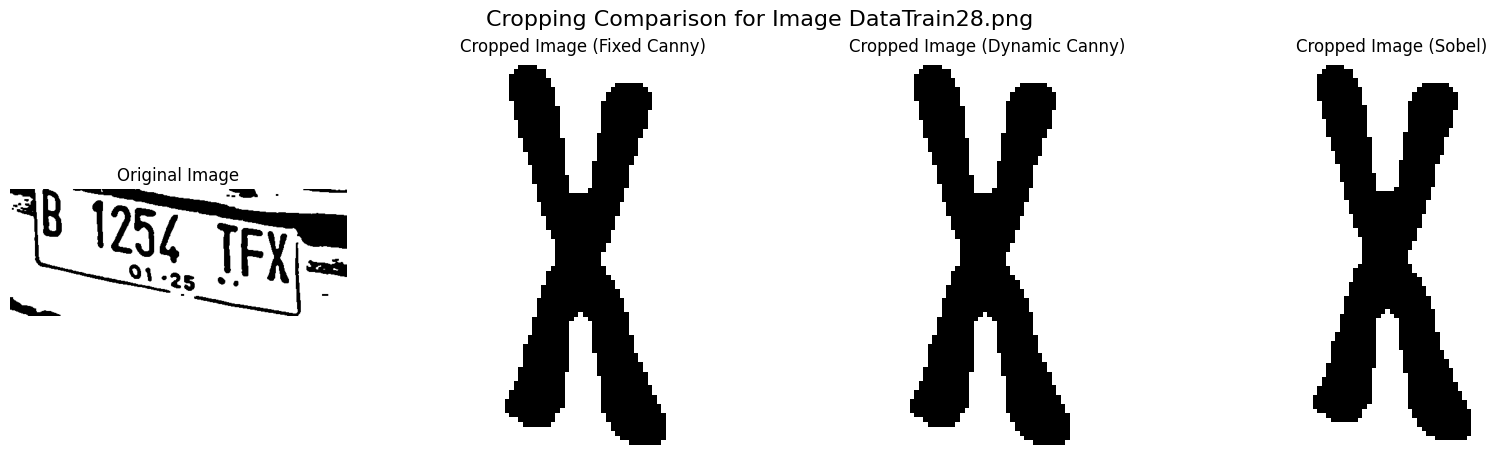

In [24]:
def crop_and_compare(image, fixed_canny_edges, dynamic_canny_edges, sobel_edges, idx):
    '''
    Fungsi untuk memotong citra berdasarkan hasil deteksi tepi Fixed Canny, Dynamic Canny, dan Sobel, 
    kemudian membandingkan hasilnya secara berdampingan.
    Input:
    - image: citra asli yang akan diproses
    - fixed_canny_edges: citra hasil deteksi tepi Canny (Fixed Threshold)
    - dynamic_canny_edges: citra hasil deteksi tepi Canny (Dynamic Threshold)
    - sobel_edges: citra hasil deteksi tepi Sobel
    - idx: indeks citra yang sedang diproses

    Output:
    - cropped_fixed_canny: citra hasil pemotongan berdasarkan Fixed Canny
    - cropped_dynamic_canny: citra hasil pemotongan berdasarkan Dynamic Canny
    - cropped_sobel: citra hasil pemotongan berdasarkan Sobel
    '''

    def crop_image(image, edges):
        # Menggunakan threshold untuk meningkatkan deteksi kontur
        _, edges_thresholded = cv2.threshold(edges, 50, 255, cv2.THRESH_BINARY)

        # Mencari kontur pada citra tepi
        contours, _ = cv2.findContours(edges_thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            # Menyaring kontur berdasarkan ukuran area minimum
            contours = [contour for contour in contours if cv2.contourArea(contour) > 500]

            if contours:  # Pastikan ada kontur setelah penyaringan
                # Menemukan kontur terbesar
                largest_contour = max(contours, key=cv2.contourArea)

                # Menghitung bounding box dari kontur terbesar
                x, y, w, h = cv2.boundingRect(largest_contour)

                # Memotong gambar berdasarkan bounding box kontur terbesar
                return image[y:y+h, x:x+w]

        # Jika tidak ada kontur yang valid, kembalikan gambar asli
        return image

    cropped_fixed_canny = crop_image(image, fixed_canny_edges)
    cropped_dynamic_canny = crop_image(image, dynamic_canny_edges)
    cropped_sobel = crop_image(image, sobel_edges)

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # Menambah kolom untuk Dynamic Canny
    axes = axes.ravel()

    # Citra asli
    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Citra hasil pemotongan berdasarkan Fixed Canny
    axes[1].imshow(cv2.cvtColor(cropped_fixed_canny, cv2.COLOR_BGR2RGB))
    axes[1].set_title('Cropped Image (Fixed Canny)')
    axes[1].axis('off')

    # Citra hasil pemotongan berdasarkan Dynamic Canny
    axes[2].imshow(cv2.cvtColor(cropped_dynamic_canny, cv2.COLOR_BGR2RGB))
    axes[2].set_title('Cropped Image (Dynamic Canny)')
    axes[2].axis('off')

    # Citra hasil pemotongan berdasarkan Sobel
    axes[3].imshow(cv2.cvtColor(cropped_sobel, cv2.COLOR_BGR2RGB))
    axes[3].set_title('Cropped Image (Sobel)')
    axes[3].axis('off')

    fig.suptitle(f'Cropping Comparison for Image {idx}', fontsize=16)
    plt.show()
    plt.close()

    return cropped_fixed_canny, cropped_dynamic_canny, cropped_sobel

# Memproses semua gambar dengan Fixed Canny, Dynamic Canny, dan Sobel
cropped_images = [
    crop_and_compare(image, fixed_canny, dynamic_canny, sobel, idx) 
    for image, (fixed_canny, dynamic_canny, sobel), idx in zip(preprocessed_image, localized_images, random_files)
]
